good0
good1
Here In DtnExampleInterface::ReportExBundleTrace:node_number_=12;simulation_duration_=802

[time-0;node-1;line-1605]enter ScheduleTx(), time-+22100000000.0ns,size=345, to node-10

[time-0;node-1;line-1605]enter ScheduleTx(), time-+32100000000.0ns,size=345, to node-10

[time-0;node-4;line-1605]enter ScheduleTx(), time-+71099999999.0ns,size=345, to node-10

[time-0;node-0;line-1605]enter ScheduleTx(), time-+255099999999.0ns,size=345, to node-4

[time-0;node-2;line-1605]enter ScheduleTx(), time-+70099999999.0ns,size=345, to node-10

[time-0;node-5;line-1605]enter ScheduleTx(), time-+42100000000.0ns,size=345, to node-10

[time-0;node-4;line-1605]enter ScheduleTx(), time-+72099999999.0ns,size=345, to node-10

[time-0;node-4;line-1605]enter ScheduleTx(), time-+75099999999.0ns,size=345, to node-10

[time-0;node-4;line-1605]enter ScheduleTx(), time-+70099999999.0ns,size=345, to node-10

[time-0;node-4;line-1605]enter ScheduleTx(), time-+78099999999.0ns,size=345, to node-10

[time-0

<IPython.core.display.Javascript object>


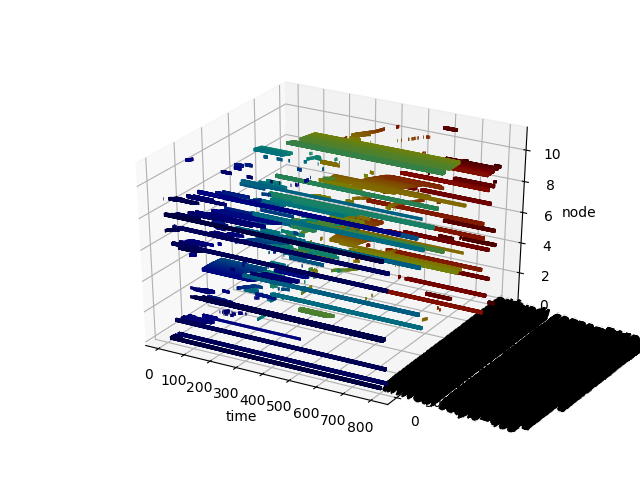

colors count=2440
len of seqno_number_list=2440
range(0, 2440)


In [2]:
%matplotlib notebook
import re
import sys
import inspect
from math import sqrt
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import jsonpickle
from matplotlib.colors import cnames
from matplotlib import animation
#==================================
# This parse script won't parse sprayandwait for full footprints, just the longest one.
##################
# define handy func
def nums(s):
    try:
        return int(s)
    except ValueError:
        return float(s)
################
#====
# read the result file
simulation_result_file = open("../../box/dtn_simulation_result/dtnrunninglog.txt", "r")
lines = simulation_result_file.readlines();
simulation_result_file.close()
#====
x_is_one_delivery_route = False
x_jsonfile_name = '!!cycle14 with Spray'
x_total_cgr_reuse_optimal_count = 0
x_total_cgr_exhaust_optimal_count = 0
x_totoal_cgr_enter_count = 0
x_simulation_time = -1
x_nodes = -1
x_sch_n = -1
x_arrive_n = 0
#                                                                                    dstination
x_time_trace_map = {} # seqno -> [src_t, sr_id, hop_t, rec_t, rec_id, hop_t, ... , rec_t, rec_id, x_simulation_time]
x_tosend_list = [] # element is also a list [source, time, destination, seqno] this is used to substitude x_schedule_list
x_schedule_list = [] # element is also a list[source, time, destination, seqno]
x_pkt_trace_map = {} # seqno -> [one_hop_snap, one_hop_snap... destination_snap]
# hop_snap , destination_snap = 
#[receive_time, receive_id, dest_id, source_id, seqno, src_generate_time, hop_transmit_time, pkt_type, is_dst, hop_id]
############
# define
def snap_print(snap) :
    print('''seqno :{0}, pkt-type={4}, receive at time-{1} at node-{2}, transmit at time-{3} at node-{5}'''
          .format(snap[4], snap[0], snap[1], snap[6], snap[7], snap[9]))
def is_snap_des(snap) :
    return snap[8]
class B_Tree(object):
    def __init__(self, pos1, pos2, pos3, pos4, data):
        self.pos1 = pos1
        self.pos2 = pos2
        self.pos3 = pos3
        self.pos4 = pos4
        self.data = data
def create_tree_from_list(list):
    root = B_Tree(None, None, None, None, None)
    return root
#############
test_string = r'Here In DtnExampleInterface::ReportExBundleTrace:node_number_=5;simulation_duration_=802'
r11 = re.compile(r'BundleTrace:node_number_=(\d+\.*\d*);simulation_duration_=(\d+\.*\d*)', re.VERBOSE)
test_regx = r11.search(test_string)
if test_regx :
    print("good0")
else :
    print("bad0")
    sys.exit()
    
strss = "[time-5.40052;node-1;line-638]NOTE:BundleTrace:good! one bun\
dle recept, it's one hop! bp_header=,destination ip=10.0.0.3,sour\
ce ip=10.0.0.1,source seqno=139,payload size=345,offset size=345,src time sta\
mp=5,hop time stamp=5,bundle type=BundlePacket"
r22 = re.compile(r'\[time-(\d+\.*\d*);node-(\d+\.*\d*);line-(\d+\.*\d*)\]NOTE:BundleTr\
ace:good!\sone\sbundle\srecept,\sit\'s\sone\shop!\sbp_header=,destination\sip=10.0.0.(\d+\.*\d*),sou\
rce\sip=10.0.0.(\d+\.*\d*),source\sseqno=(\d+\.*\d*),payload\ssize=(\d+\.*\d*),offset\ssi\
ze=(\d+\.*\d*),src\stime\sstamp=(\d+\.*\d*),hop\stime\sstamp=(\d+\.*\d*),bundle\stype=([a-zA-Z]+)', re.VERBOSE)
hopt = r22.match(strss)
if hopt :
    print("good1")
else :
    print("bad1")
    sys.exit()
    
#================================================ dividing parse ========================================
# parse for x_ nodes and x_ simualtion_time
# parse for bundle trace and schedule
avoid_log_twice_bug = False
for line in lines :
    #In DtnExampleRunner
    r0 = re.compile(r'In\sDtnExampleRunner', re.VERBOSE)
    parse_begin = r0.search(line)
    if parse_begin :
        avoid_log_twice_bug = True
        continue
    elif avoid_log_twice_bug :
        # do nothing
        onenomeaning = 1
    else :
        continue
    
    #BundleTrace:node_number_=5;simulation_duration_=802
    r1 = re.compile(r'BundleTrace:node_number_=(\d+\.*\d*);simulation_duration_=(\d+\.*\d*)', re.VERBOSE)
    simulation_preview = r1.search(line)
    
    #[time-5.40052;node-1;line-638]NOTE:BundleTrace:good! one bundle recept, it's one hop! bp_header=,destination ip=10.0.0.3,source ip=10.0.0.1,source seqno=139,payload size=345,offset size=345,src time stamp=5,hop time stamp=5,bundle type=BundlePacket
    r2 = re.compile(r'''\[time\-(\d+\.*\d*);node\-(\d+\.*\d*);line\-(\d+\.*\d*)\]NOTE:BundleTrace:go
    od!\sone\sbundle\srecept\,\sit\'s\sone\shop!\sbp_header=\,destination\sip=10\.0\.0\.(\d+\.*\d*)\,sour
    ce\sip=10\.0\.0\.(\d+\.*\d*)\,source\sseqno=(\d+\.*\d*)\,payload\ssize=(\d+\.*\d*)\,offset\ssiz
    e=(\d+\.*\d*)\,src\stime\sstamp=(\d+\.*\d*)\,hop\stime\ssta
    mp=(\d+\.*\d*)\,hop\sip=10\.0\.0\.(\d+\.*\d*)\,bundle\stype=([a-zA-Z]+)''', re.VERBOSE)
    hop = r2.search(line)
    
    #[time-3.30744;node-1;line-630]NOTE:BundleTrace:Great! one bundle arrive destination! bp_header=,destination ip=10.0.0.2,source ip=10.0.0.1,source seqno=75,payload size=345,offset size=345,src time stamp=3,hop time stamp=3,bundle type=BundlePacket
    r3 = re.compile(r'''\[time\-(\d+\.*\d*);node\-(\d+\.*\d*);line\-(\d+\.*\d*)\]NOTE:BundleTrace:Great!\son
    e\sbundle\sarrive\sdestination!\sbp_header=\,destination\sip=10\.0\.0\.(\d+\.*\d*)\,so
    urce\sip=10\.0\.0\.(\d+\.*\d*)\,source\sseqno=(\d+\.*\d*)\,payload\ssize=(\d+\.*\d*)\,offset\ss
    ize=(\d+\.*\d*)\,src\stime\sstamp=(\d+\.*\d*)\,hop\stime\ssta
    mp=(\d+\.*\d*)\,hop\sip=10\.0\.0\.(\d+\.*\d*)\,bundle\stype=([a-zA-Z]+)''', re.VERBOSE)
    destination = r3.search(line)
    
    #[time-0;node-0;line-1553]enter ScheduleTx(), time-+3000000000.0ns,size=345, to node-1
    r4 = re.compile(r'''node\-(\d+\.*\d*);line\-(\d+\.*\d*)]enter\sScheduleTx\(\)\,\sti
    me\-\+(\d+\.*\d*)ns\,size=(\d+\.*\d*)\,\sto\snode\-(\d+\.*\d*)''', re.VERBOSE)
    schedule = r4.search(line)
    
    #BundleTrace:Itisonedeliverymethon
    r5 = re.compile(r'''BundleTrace:Itisonedeliverymethon''', re.VERBOSE)
    isonedelivery = r5.search(line)
    
    #ScheduleTx,inToSendBundle(),bp_header=,destination ip=10.0.0.4,source ip=10.0.0.3,source seqno=47,payload size=345,offset size=345,src time stamp=0.562494,hop time stamp=0.562494,hop ip=10.0.0.3,bundle type=BundlePacket
    r6 = re.compile(r'''ScheduleTx\,inToSendBundle\(\)\,bp_header=\,destination\sip=10\.0\.0\.(\d+\.*\d*)\,so
    urce\sip=10\.0\.0\.(\d+\.*\d*)\,source\sseqno=(\d+\.*\d*)\,payload\ssize=(\d+\.*\d*)\,offset\ss
    ize=(\d+\.*\d*)\,src\stime\sstamp=(\d+\.*\d*)\,hop\stime\ssta
    mp=(\d+\.*\d*)\,hop\sip=10\.0\.0\.(\d+\.*\d*)\,bundle\stype=([a-zA-Z]+)''', re.VERBOSE)
    tosendbundle = r6.search(line)
    
    #BundleTrace:entertimes=1times
    r7 = re.compile(r'''BundleTrace:entertimes=(\d+\.*\d*)times''', re.VERBOSE)
    cgrcount = r7.search(line)
    
    #may make bad routing-2
    r8 = re.compile(r'''may\smake\sbad\srouting-2''', re.VERBOSE)
    cgr_reuse = r8.search(line)
    
    #may make bad routing-1
    r9 = re.compile(r'''may\smake\sbad\srouting-1''', re.VERBOSE)
    cgr_exhaust = r9.search(line)
    
    if schedule :
        print(line)
        sche_source = int(nums(schedule.group(1)))
        sche_time = float(nums(schedule.group(3)) / 1000000000.0)
        sche_destination = int(nums(schedule.group(5)))
        tmp = [sche_source, sche_time, sche_destination, -1]
        x_schedule_list.append(tmp)
    elif cgr_reuse :
        x_total_cgr_reuse_optimal_count += 1
    elif cgr_exhaust :
        x_total_cgr_exhaust_optimal_count += 1
    elif cgrcount :
        print(line)
        x_totoal_cgr_enter_count += int(nums(cgrcount.group(1)))
    elif tosendbundle :
        print(line)
        tosend_source = int(nums(tosendbundle.group(2)) - int(1))
        tosend_time = float(nums(tosendbundle.group(6)))
        tosend_destination = int(nums(tosendbundle.group(1)) - int(1))
        tosend_seqno = int(nums(tosendbundle.group(3)))
        tmp = [tosend_source, tosend_time, tosend_destination, tosend_seqno]
        x_tosend_list.append(tmp)
    elif isonedelivery :
        print(line)
        x_is_one_delivery_route = True
    elif hop :
        print(line)
        hop_receive_time = float(nums(hop.group(1)))
        hop_receive_id = int(nums(hop.group(2)))
        hop_dest_id = int(nums(hop.group(4)) - int(1))
        hop_source_id = int(nums(hop.group(5)) - int(1))
        hop_seqno = int(nums(hop.group(6)))
        hop_src_generate_time = float(nums(hop.group(9))) # TODO
        hop_hop_transmit_time = float(nums(hop.group(10)))
        hop_hop_id = int(nums(hop.group(11)) - int(1))
        hop_pkt_type = hop.group(12)
        if (hop_hop_transmit_time > hop_receive_time) :
            print('receive time:{0} should < hop_transmit time{1}'.format(hop_receive_time, hop_hop_transmit_time))
            sys.exit()
        tmp = [hop_receive_time, hop_receive_id, hop_dest_id, hop_source_id, hop_seqno,
               hop_src_generate_time, hop_hop_transmit_time, hop_pkt_type, False, hop_hop_id]
        if hop_seqno in x_pkt_trace_map.keys():
            old_list = x_pkt_trace_map[hop_seqno]
            old_list.append(tmp)
            old_list.sort(key=lambda tup: tup[0])
            x_pkt_trace_map[hop_seqno] = old_list
        else:
            new_list = []
            new_list.append(tmp)
            x_pkt_trace_map[hop_seqno] = new_list
    elif simulation_preview :
        print(line)
        x_nodes = int(simulation_preview.group(1))
        x_simulation_time = float(simulation_preview.group(2))
    elif destination :
        print(line)
        dst_receive_time = float(nums(destination.group(1)))
        dst_receive_id = int(nums(destination.group(2)))
        dst_dst_id = int(nums(destination.group(4)) - int(1))
        dst_src_id = int(nums(destination.group(5)) - int(1))
        dst_seqno = int(nums(destination.group(6)))
        dst_src_generate_time = float(nums(destination.group(9)))
        dst_hop_transmit_time = float(nums(destination.group(10)))
        dst_hop_id = int(nums(destination.group(11)) - int(1))
        dst_pkt_type = destination.group(12)
        if (dst_hop_transmit_time > dst_receive_time) :
            print('receive time')
            sys.exit()
        tmp = [dst_receive_time, dst_receive_id, dst_dst_id, dst_src_id, dst_seqno,
               dst_src_generate_time, dst_hop_transmit_time, dst_pkt_type, True, dst_hop_id]
        if dst_seqno in x_pkt_trace_map.keys() :
            old_list = x_pkt_trace_map[dst_seqno]
            old_list.append(tmp)
            old_list.sort(key=lambda tup: tup[0])
            x_pkt_trace_map[dst_seqno] = old_list
        else :
            new_list = []
            new_list.append(tmp)
            x_pkt_trace_map[dst_seqno] = new_list
            
#========================================= end of parse ===================================================

print(r'============= dividing end of parse =============')
if (x_nodes == -1) or (x_simulation_time == -1) :
    print('error_04')
    sys.exit()
#================ now we have every thing we need, refine the data and prepare for visualization
#===== refine x_schedule_list
for sch in x_schedule_list :
    sk = [sch[0], sch[1], sch[2]] # s, t, d
    sn = sch[3]
    if sn != -1 :
        print('error_03')
        sys.exit()
    for key, value in x_pkt_trace_map.items() : #
        #print('value len={0}'.format(len(value)))
        #print(value)
        tk = [value[0][3], value[0][5], value[0][2]]
        seqno = value[0][4]
        if (tk[0] == sk[0] and tk[2] == sk[2] and tk[1] - sk[1] < 0.1) :
            sn = seqno
            break
    if (sn != -1) :
        sch[3] = sn
    else :
        print('warn_05:this may happen when one pkt scheduled but not successfully hoped')

print('============= \n === print your schedule')
print(x_schedule_list)
print('============= \n === print your tosendbundle')
print(x_tosend_list)
#===================================== get graph needed list
#
x_sch_n = len(x_tosend_list)
print('==============\n print your x_pkt_trace_map')
print(x_pkt_trace_map)
#######################################
####################
#definition
def get_x_time_trace_map_detail(p_x_time_trace_map, p_x_tosend_list, p_x_pkt_trace_map, ref_x_arrive_n) :
    ref_x_arrive_n = 0
    for sch in p_x_tosend_list :
            src_t = sch[1]
            seqno = sch[3]
            if seqno == -1 :
                print('error_01')
                sys.exit()
            sr_id = sch[0]
            tmp = []
            tmp.extend([src_t, sr_id])
            if seqno in p_x_pkt_trace_map :
                print('key exist')
                for trace in p_x_pkt_trace_map[seqno] :
                    if trace[4] != seqno :
                        print('error_02')
                        sys.exit()
                    is_dst = bool(trace[8])
                    hop_t = trace[6]
                    rec_t = trace[0]
                    rec_id = trace[1]
                    tmp.extend([hop_t, rec_t, rec_id])
                    if is_dst :
                        tmp.append(x_simulation_time)
                if len(tmp) % 3 == 0 :
                    ref_x_arrive_n += 1
                    p_x_time_trace_map[seqno] = tmp 
                else :
                    print('there is one pkt don\'t arrive destination')
                    p_x_time_trace_map[seqno] = tmp
            else :
                print('key not exist-{0}'.format(seqno))
                p_x_time_trace_map[seqno] = tmp
    return ref_x_arrive_n
def get_x_time_trace_map(p_x_time_trace_map, p_x_tosend_list, p_x_pkt_trace_map, ref_x_arrive_n) :
    ref_x_arrive_n = 0
    if x_is_one_delivery_route :
        ref_x_arrive_n = get_x_time_trace_map_detail(p_x_time_trace_map,p_x_tosend_list, p_x_pkt_trace_map, ref_x_arrive_n)
    else :
        print('if not one delivery route, this would cause one seqno -> multiply path, it\'s hard to parse, would\
        differ against normal one delivery parse')
        print('============ print all hop snap ==============')
        for key, snaps in p_x_pkt_trace_map.items() :
            for snap in snaps :
                snap_print(snap)
        print('================ then we would try to find destination delivery in p_x_pkt_trace_map =========')
        for key, snaps in p_x_pkt_trace_map.items() :
            #treeob = get_B_Tree_from_key_snaps(key, snaps, p_x_tosend_list)
            pkt_uni_list = get_list_of_pkt_trace(key, snaps, p_x_tosend_list)
            reversed_uni_list = []
            for v in reversed(pkt_uni_list) :
                reversed_uni_list.append(v)
            p_x_pkt_trace_map[key] = reversed_uni_list
        print('================ debug  p_x_pkt_trace_map 1=========')
        print(p_x_pkt_trace_map)
        print('================ debug  p_x_pkt_trace_map 1=========')
        ref_x_arrive_n = get_x_time_trace_map_detail(p_x_time_trace_map,p_x_tosend_list, p_x_pkt_trace_map, ref_x_arrive_n)
    return ref_x_arrive_n
def get_list_of_pkt_trace(key, snaps, p_x_tosend_list) :
    snaps_count = len(snaps)
    source_id = None
    for y_tosend in p_x_tosend_list :
        if key == y_tosend[3] :
            source_id = y_tosend[0]
    dest_snap = None
    for snap in snaps :
        if is_snap_des(snap) :
            dest_snap = snap
    if dest_snap == None :
        dest_snap = snaps[snaps_count - 1]
    return_list = []
    if dest_snap == None :
        return return_list
    cur_snap = dest_snap
    return_list.append(cur_snap)
    loop_count = 0
    if dest_snap[3] != source_id :
        print('source ={0}-{1}'.format(source_id, dest_snap[3]))
        print("error_09")
        sys.exit()
    while cur_snap[9] != source_id and loop_count <= 40 :
        loop_count += 1
        for snap in snaps :
            print("key is {2}, cur_snap from-{0}, snap is{1}".format(cur_snap[9], snap[1], key))
            if cur_snap[9] == snap[1] and snap[6] < cur_snap[0] :
                cur_snap = snap
                return_list.append(cur_snap)
                break
    if loop_count > 40 :
        print("error_08")
        sys.exit()
    return return_list
def get_B_Tree_from_key_snaps(key, snaps, pp_x_tosend_list) :
    r = 1
    #unreached_count = len(snaps)
    #have_dest = False
    #dest_snap = None
    #longest_snap_chain = None
    #for snap in snaps :
    #    if is_snap_des(snap) :
    #        dest_snap = snap
    #source_id = None
    #tree_root = None
    #for y_tosend in pp_x_tosend_list :
    #    if key == y_tosend[3] :
    #        source_id = y_tosend[0]
    #if source_id == None :
    #    print("error_07")
    #    sys.exit()
    #else :
    #    tree_root = B_Tree(None, None, None, None, source_id)
    #cur_trans_id = source_id
    #while unreached_count > 0 :
    #    tree_child = [None, None, None, None]
     #    child_index = 0
    #    for snap in snaps :
    #        if snap[9] == cur_trans_id ##
    #       tree_childe[child_index] = snap
    #        child_index += 1
    #        unreached_count -= 1
    #--- Not implement yet
    #return tree_root
def handy_print_2(seqno, p_x_tosend_list) :
    for xs in p_x_tosend_list :
        if xs[3] == seqno :
            print('schedule is: from node-{0} to node-{1} at time-{2}'.format(xs[0], xs[2], xs[1]))
            break
def handy_print_0(st, et, nid) :
    print('from time-{0} => time-{1} in node-{2}'.format(st, et, nid))
def handy_print_1(key, value, p_x_tosend_list) :
    print('==================\npkt-seqno:{0}, trace is: '.format(key))
    n_v = int(len(value) / 3)
    is_arrived_traffic = False
    if (n_v * 3 == len(value)) :
        is_arrived_traffic = True
    if (is_arrived_traffic) :
        for cur in range(0, n_v, 1) :
            if cur == n_v - 1 :
                print('received by node-{1} at time-{0} destination :)'.format(value[cur * 3], value[cur * 3 + 1]))
            else :
                handy_print_0(value[cur * 3], value[cur * 3 + 2], value[cur * 3 + 1])
        print('arrived destination\n')
    else :
        for cur in range(0, n_v + 1, 1) :
            if cur == n_v :
                print('received by node-{1} at time-{0}, not destination :('.format(value[cur * 3], value[cur * 3 + 1]))
                if cur == 0 :
                    print('this bundle may not be transmit out from source')
            else :
                handy_print_0(value[cur * 3], value[cur * 3 + 2], value[cur * 3 + 1])
        print('not arrived destination\n')
    handy_print_2(key, p_x_tosend_list)
def handy_draw_0(ax0, st, et, nid, seqnoindex, c) :
    dx = et - st
    ax0.bar3d(st, seqnoindex, nid, dx + 1.0, 0.2, 0.2, alpha=0.1, color=c, linewidth=0) # alpha = abs(dz[i]/max(dz))
class JSONOB(object):
    def __init__(self, name, tosend_list_ob, time_trace_map_ob):
        self.name = name
        self.tosend_list_ob = tosend_list_ob
        self.time_trace_map_ob = time_trace_map_ob
    def get_name(self) :
        return self.name
    def get_map(self) :
        return self.time_trace_map_ob
    def get_list(self) :
        return self.tosend_list_ob
def save_this_jsonob_as(filename, jsonob_to) :
    fullpathname = './stuff folder/' + filename
    serialized_json = jsonpickle.encode(jsonob_to)
    with open(fullpathname, "w") as text_file:
        print(serialized_json, file=text_file)
def draw_it(p_x_tosend_list, p_x_time_trace_map, p_x_simulation_time) :
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    colors = plt.cm.jet(np.linspace(0, 1, len(p_x_tosend_list)))
    seqno_number_list = []
    for xsele in p_x_tosend_list :
        seqno_number_list.append(xsele[3])  
    print('colors count={0}'.format(len(colors)))
    print('len of seqno_number_list={0}'.format(len(seqno_number_list)))
    print(range(0, len(seqno_number_list), 1))
    for c, zseqnoindex in zip(colors, range(0, len(seqno_number_list), 1)):
        this_seqno_no = seqno_number_list[zseqnoindex]
        trace_list_of_seqno = p_x_time_trace_map[this_seqno_no]
        rt_count = int(len(trace_list_of_seqno) / 3)
        is_arrived_traffic_0 = False
        if (rt_count * 3 == len(trace_list_of_seqno)) :
            is_arrived_traffic_0 = True
            
        if is_arrived_traffic_0 :
            for cur in range(0, rt_count, 1) :
                if cur == rt_count - 1 :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3 + 2], \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)
                    ax.text(p_x_simulation_time, zseqnoindex, 0\
                            , 'arrived! seqno={0}'.format(seqno_number_list[zseqnoindex]), 'x')
                else :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3 + 2], \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)
        else :
            for cur in range(0, rt_count + 1, 1) :
                if cur == rt_count :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3] + 1, \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)
                    ax.text(p_x_simulation_time, zseqnoindex, 0\
                            , 'missed! seqno={0}'.format(seqno_number_list[zseqnoindex]), 'x')
                else :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3 + 2], \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)

    ax.set_xlabel('time')
    ax.set_ylabel('seqno')
    ax.set_zlabel('node')
    plt.show()
#end of definition
#################################
###################################
print('===================================================================================================\
\n===================== report parse result ================')
x_arrive_n = get_x_time_trace_map(x_time_trace_map, x_tosend_list, x_pkt_trace_map, x_arrive_n)
title_str = '{0} / {1} arrived'.format(x_arrive_n, x_sch_n)
print(title_str)
print('====================== serialize to json format =====================')
name = '{4}-nodeN-{0}-timeT-{1}-arriveN-{2}-scheduleN-{3}'.\
                    format(x_nodes, x_simulation_time, x_arrive_n, x_sch_n, x_jsonfile_name)
jsonob_this = JSONOB(name, x_tosend_list, x_time_trace_map)
save_this_jsonob_as(name, jsonob_this)

print('====================== print result in plain text =====================')
for key, value in x_time_trace_map.items() :
    handy_print_1(key, value, x_tosend_list)
print(x_time_trace_map)

print('================================= dividing ========================')
draw_it(x_tosend_list, x_time_trace_map, x_simulation_time)

if x_totoal_cgr_enter_count > 0 :
    print('================================= CGR only print for debug ========================')
    print('totoal cgr enter count = {0}'.format(x_totoal_cgr_enter_count))
    print('running time optimal routing result successive routing reuse count = {0}'.format(x_total_cgr_reuse_optimal_count))
    print('running time optimal routing result exhaust routing reuse count = {0}'.format(x_total_cgr_exhaust_optimal_count))